# Assignment #2 : Regression Analysis and Model Selection

<b>Mohammed Abed Alkareem - 1210708</b><br>
<b>Mosa Sbeih - 1211250</b>



This dataset, scraped from the YallaMotorswebsite using Python and the Requests-HTML library, includes around 6,750 rows and 9 columns. It’s well-suited for Exploratory Data Analysis (EDA) and machine learning tasks, particularly for predictive modeling using algorithms like Linear Regression. The main objective of this dataset is to predict car prices, making it ideal for developing regression models to understand the relationship between various features (e.g., car make, model, year, mileage, engine size, etc.) and the target variable (car price).

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from scipy.stats import zscore
from itertools import combinations_with_replacement

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge




## Download Dataset

In [ ]:
!kaggle datasets download ahmedwaelnasef/cars-dataset

Dataset URL: https://www.kaggle.com/datasets/ahmedwaelnasef/cars-dataset
License(s): apache-2.0
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 57.9MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('cars-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('cars-dataset')

## Import Dataset

In [ ]:
car_df = pd.read_csv('cars-dataset/cars.csv')

## Exploring the dataset

In [ ]:
car_df.head(10)

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa
5,Honda HR-V 2021 1.8 i-VTEC EX,"SAR 95,335",1.8,4,140,190,5 Seater,honda,ksa
6,Peugeot Expert 2021 Van L3 A/T,"SAR 82,845",2.0,4,120,170,N A,peugeot,ksa
7,Peugeot Expert 2021 Van L3 M/T,"SAR 76,545",2.0,4,120,170,N A,peugeot,ksa
8,Renault Koleos 2021 2.5L LE (4WD),"SAR 116,900",2.5,4,170,199,5 Seater,renault,ksa
9,Ford Bronco 2021 2.7T Outer Banks,"SAR 238,000",2.7,6,542,5 Seater,6.9,ford,ksa


In [ ]:
original_shape = car_df.shape
print("number of rows in the dataset are: ", original_shape[0])
print("number of columns in the dataset are: ", original_shape[1])

number of rows in the dataset are:  6308
number of columns in the dataset are:  9


In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


In [ ]:
car_df.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


In [ ]:
print(car_df.columns)

Index(['car name', 'price', 'engine_capacity', 'cylinder', 'horse_power',
       'top_speed', 'seats', 'brand', 'country'],
      dtype='object')


## Data Preprocessing

### Price Column

it was notices the the target(price) column was written mainly in (Currency Price) format, so we need to remove the currency symbol and convert it to float and unify all prices to be in the same currency (USD).

In [ ]:
#get currencies in the price column
currencies=set()

for price in car_df['price']:
    if not any(chr.isdigit() for chr in price):
        car_df['price'] = car_df['price'].replace(price, -1) #replace non-numeric prices with -1
    else:
            currencies.add(price.split(' ')[0])



In [ ]:
currencies

{'AED', 'BHD', 'EGP', 'F8', 'KWD', 'OMR', 'QAR', 'SAR'}

In [ ]:
# the exchange rates of the currencies to USD
exchange_rates = {
    'AED': 3.6725,  # 1 USD = 3.6725 AED
    'BHD': 0.377,   # 1 USD = 0.377 BHD
    'EGP': 30.22,   # 1 USD = 30.22 EGP
    'KWD': 0.308,   # 1 USD = 0.308 KWD
    'OMR': 0.384,   # 1 USD = 0.384 OMR
    'QAR': 3.64,    # 1 USD = 3.64 QAR
    'SAR': 3.75     # 1 USD = 3.75 SAR
}


In [ ]:
# convert the prices to USD

converted_prices = []

for price in car_df['price']:
    if price == -1:
        converted_prices.append(np.nan) # add nan for non-numeric prices
    else:
        currency = price.split(' ')[0]
        try:
            price_value = float(price.split(' ')[1].replace(',', '')) # remove the comma in the number
            converted_price = price_value / exchange_rates[currency]
            #add only 3 digits after the decimal point
            converted_price = round(converted_price, 3)
            converted_prices.append(converted_price)
        except (ValueError, IndexError):
            converted_prices.append(np.nan) # add nan for any error in the conversion

car_df['price_usd'] = converted_prices
car_df.drop('price', axis=1, inplace=True)

In [ ]:
car_df.head()

,car name,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,price_usd
0,Fiat 500e 2021 La Prima,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa,NaN
1,Peugeot Traveller 2021 L3 VIP,2.0,4,180,8 Seater,8.8,peugeot,ksa,37486.667
2,Suzuki Jimny 2021 1.5L Automatic,1.5,4,102,145,4 Seater,suzuki,ksa,26342.667
3,Ford Bronco 2021 2.3T Big Bend,2.3,4,420,4 Seater,7.5,ford,ksa,52800.000
4,Honda HR-V 2021 1.8 i-VTEC LX,1.8,4,140,190,5 Seater,honda,ksa,NaN


In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car name         6308 non-null   object 
 1   engine_capacity  6308 non-null   object 
 2   cylinder         5684 non-null   object 
 3   horse_power      6308 non-null   object 
 4   top_speed        6308 non-null   object 
 5   seats            6308 non-null   object 
 6   brand            6308 non-null   object 
 7   country          6308 non-null   object 
 8   price_usd        4979 non-null   float64
dtypes: float64(1), object(8)
memory usage: 443.7+ KB


In [ ]:
car_df['price_usd'].describe()

,price_usd
count,4.979000e+03
mean,7.222527e+04
std,1.069692e+05
min,4.765056e+03
25%,2.568890e+04
50%,4.752604e+04
75%,8.385989e+04
max,3.550613e+06


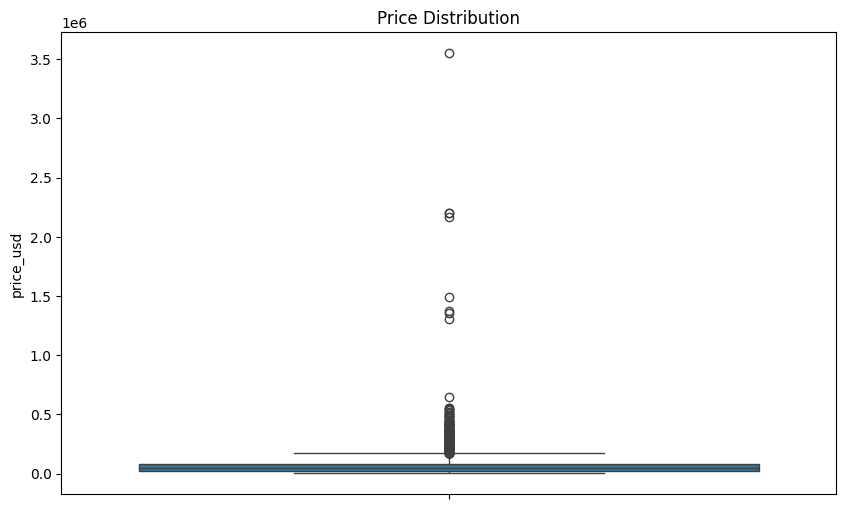

In [ ]:
# draw boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=car_df['price_usd'])
plt.title('Price Distribution')
plt.show()

#### Handling Outliers

In [ ]:

# drop any row that has a price greater than 3M USD
car_df = car_df[(car_df['price_usd'] < 3000000) | (car_df['price_usd'].isna())]


In [ ]:
car_df['price_usd'].describe()

,price_usd
count,4.978000e+03
mean,7.152652e+04
std,9.493792e+04
min,4.765056e+03
25%,2.568176e+04
50%,4.750307e+04
75%,8.374334e+04
max,2.200604e+06


it was notices that after removing unreal prices, the range of the prices is between 4.7k and 2.2M, wich may be acceptable, so we will keep the prices as they are.

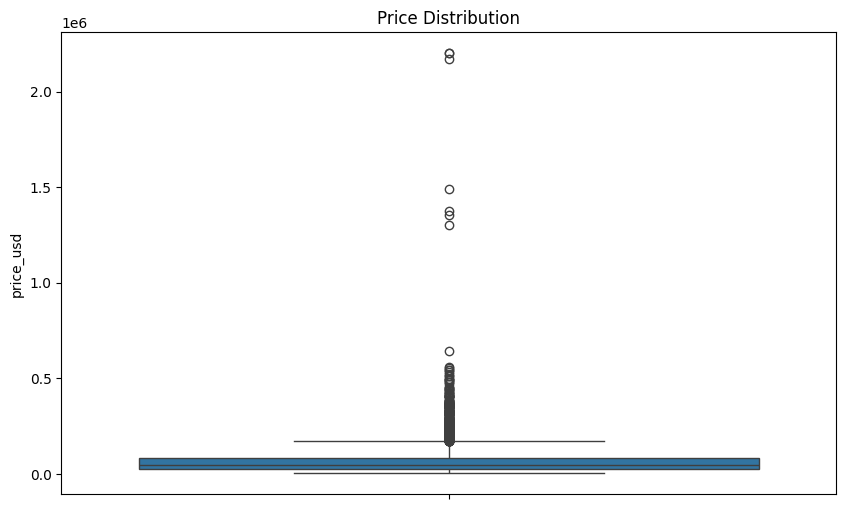

In [ ]:
#draw boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=car_df['price_usd'])
plt.title('Price Distribution')
plt.show()

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6307 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car name         6307 non-null   object 
 1   engine_capacity  6307 non-null   object 
 2   cylinder         5683 non-null   object 
 3   horse_power      6307 non-null   object 
 4   top_speed        6307 non-null   object 
 5   seats            6307 non-null   object 
 6   brand            6307 non-null   object 
 7   country          6307 non-null   object 
 8   price_usd        4978 non-null   float64
dtypes: float64(1), object(8)
memory usage: 492.7+ KB


### Engine Capacity Column

In [ ]:
engine_capacities = []

for val in car_df['engine_capacity']:
    try:
        val = float(val)
        if val <= 0:
            engine_capacities.append(np.nan) # add nan for negative or zero values
        elif val < 10:
            engine_capacities.append(val * 1000) # convert from liter to cm3
        else:
            engine_capacities.append(val)

    except ValueError: # if the value is not a number
        engine_capacities.append(np.nan)


car_df['engine_capacity_edited'] = engine_capacities

car_df.drop('engine_capacity', axis=1, inplace=True)



In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6307 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                6307 non-null   object 
 1   cylinder                5683 non-null   object 
 2   horse_power             6307 non-null   object 
 3   top_speed               6307 non-null   object 
 4   seats                   6307 non-null   object 
 5   brand                   6307 non-null   object 
 6   country                 6307 non-null   object 
 7   price_usd               4978 non-null   float64
 8   engine_capacity_edited  6161 non-null   float64
dtypes: float64(2), object(7)
memory usage: 492.7+ KB


#### Handling Outliers

In [ ]:
car_df['engine_capacity_edited'].describe()

,engine_capacity_edited
count,6161.000000
mean,2879.888979
std,1309.862788
min,140.000000
25%,2000.000000
50%,2500.000000
75%,3600.000000
max,6800.000000


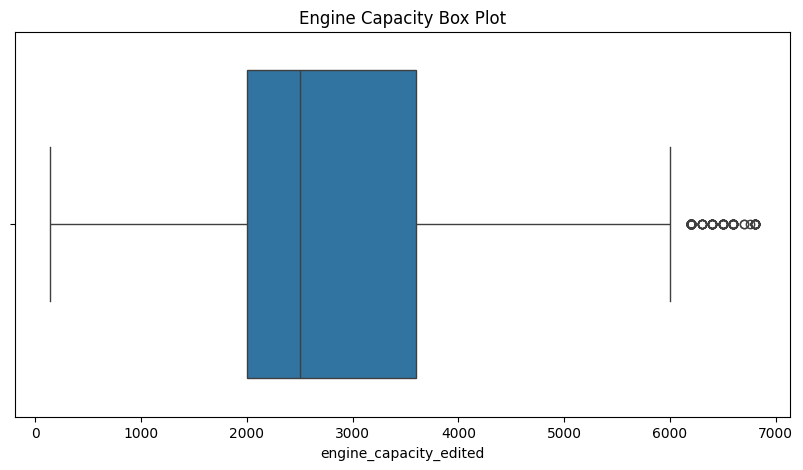

In [ ]:

# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['engine_capacity_edited'])
plt.title('Engine Capacity Box Plot')
plt.show()



the engine capacity is in cubic centimeters can be from 600 to 8000 cm^3

In [ ]:
car_df = car_df[(car_df['engine_capacity_edited'].isna()) | ((car_df['engine_capacity_edited'] >= 600) & (car_df['engine_capacity_edited'] <= 8000))]

In [ ]:
car_df['engine_capacity_edited'].describe()

,engine_capacity_edited
count,6160.000000
mean,2880.333766
std,1309.503736
min,999.000000
25%,2000.000000
50%,2500.000000
75%,3600.000000
max,6800.000000


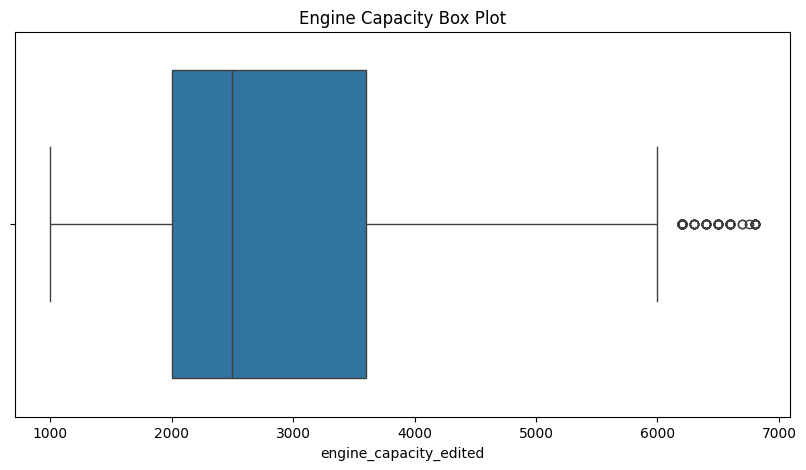

In [ ]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['engine_capacity_edited'])
plt.title('Engine Capacity Box Plot')
plt.show()

In [ ]:
car_df.head()

,car name,cylinder,horse_power,top_speed,seats,brand,country,price_usd,engine_capacity_edited
0,Fiat 500e 2021 La Prima,"N/A, Electric",Single,Automatic,150,fiat,ksa,NaN,NaN
1,Peugeot Traveller 2021 L3 VIP,4,180,8 Seater,8.8,peugeot,ksa,37486.667,2000.0
2,Suzuki Jimny 2021 1.5L Automatic,4,102,145,4 Seater,suzuki,ksa,26342.667,1500.0
3,Ford Bronco 2021 2.3T Big Bend,4,420,4 Seater,7.5,ford,ksa,52800.000,2300.0
4,Honda HR-V 2021 1.8 i-VTEC LX,4,140,190,5 Seater,honda,ksa,NaN,1800.0


### Cylinder Column

In [ ]:
cylinders = []
c = set()
for cylinder in car_df['cylinder']:
    try:
        cylinder=int(cylinder) # convert to int

        if cylinder <= 0:
            cylinders.append(np.nan) # add nan for negative or zero values
        else:
            cylinders.append(cylinder)
    except ValueError:
        cylinders.append(np.nan) # add nan for any error in the conversion

car_df['cylinder_edited'] = cylinders
car_df.drop('cylinder', axis=1, inplace=True)

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6306 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                6306 non-null   object 
 1   horse_power             6306 non-null   object 
 2   top_speed               6306 non-null   object 
 3   seats                   6306 non-null   object 
 4   brand                   6306 non-null   object 
 5   country                 6306 non-null   object 
 6   price_usd               4977 non-null   float64
 7   engine_capacity_edited  6160 non-null   float64
 8   cylinder_edited         5572 non-null   float64
dtypes: float64(3), object(6)
memory usage: 492.7+ KB


#### Handling Outliers

In [ ]:

car_df['cylinder_edited'].describe()

,cylinder_edited
count,5572.000000
mean,5.390524
std,1.873117
min,3.000000
25%,4.000000
50%,4.000000
75%,6.000000
max,12.000000


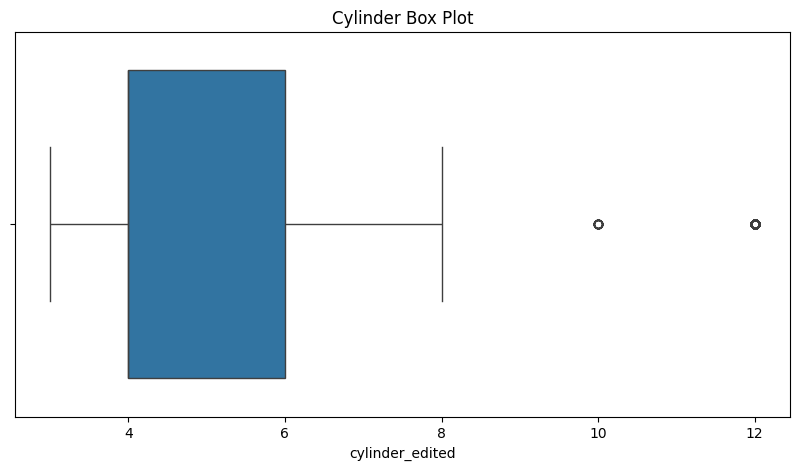

In [ ]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['cylinder_edited'])
plt.title('Cylinder Box Plot')
plt.show()

In [ ]:
# set of cylinder values
car_df['cylinder_edited'].unique()
#accepted

array([nan,  4.,  6., 12.,  8.,  3.,  5., 10.])

the number of cylinders can be from 3 to 16 cylinders so there is no need to remove any outliers.

In [ ]:
car_df.head()

,car name,horse_power,top_speed,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited
0,Fiat 500e 2021 La Prima,Single,Automatic,150,fiat,ksa,NaN,NaN,NaN
1,Peugeot Traveller 2021 L3 VIP,180,8 Seater,8.8,peugeot,ksa,37486.667,2000.0,4.0
2,Suzuki Jimny 2021 1.5L Automatic,102,145,4 Seater,suzuki,ksa,26342.667,1500.0,4.0
3,Ford Bronco 2021 2.3T Big Bend,420,4 Seater,7.5,ford,ksa,52800.000,2300.0,4.0
4,Honda HR-V 2021 1.8 i-VTEC LX,140,190,5 Seater,honda,ksa,NaN,1800.0,4.0


### Horsepower Column

In [ ]:
hourses = []

for horse in car_df['horse_power']:
    try:
        horse = float(horse) # convert to float
        if horse <= 0:
            hourses.append(np.nan) # add nan for negative or zero values
        else:
            hourses.append(horse)
    except ValueError:
        hourses.append(np.nan) # add nan for any error in the conversion

car_df['horse_power_edited'] = hourses
car_df.drop('horse_power', axis=1, inplace=True)

In [ ]:
car_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6306 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                6306 non-null   object 
 1   top_speed               6306 non-null   object 
 2   seats                   6306 non-null   object 
 3   brand                   6306 non-null   object 
 4   country                 6306 non-null   object 
 5   price_usd               4977 non-null   float64
 6   engine_capacity_edited  6160 non-null   float64
 7   cylinder_edited         5572 non-null   float64
 8   horse_power_edited      6184 non-null   float64
dtypes: float64(4), object(5)
memory usage: 492.7+ KB


#### Handling Outliers

In [ ]:

car_df['horse_power_edited'].describe()

,horse_power_edited
count,6184.000000
mean,292.107536
std,178.948366
min,12.000000
25%,168.000000
50%,255.000000
75%,367.000000
max,5050.000000


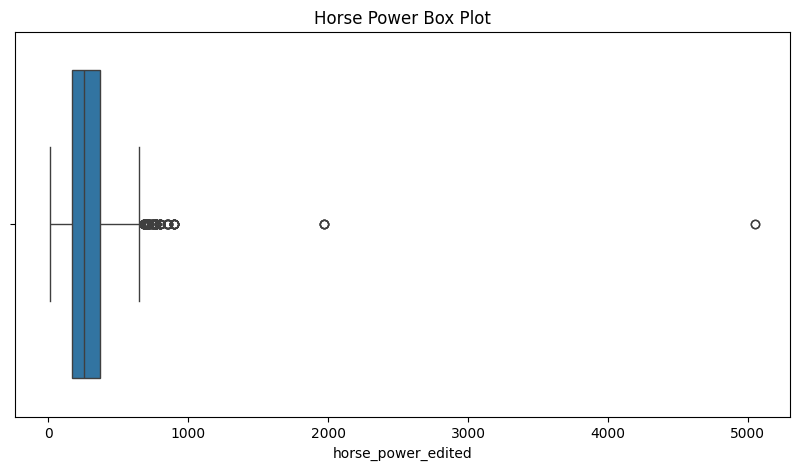

In [ ]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['horse_power_edited'])
plt.title('Horse Power Box Plot')
plt.show()

min horse powwer in 50 and max 2000

In [ ]:
car_df = car_df[(car_df['horse_power_edited'].isna()) | ((car_df['horse_power_edited'] >= 50) & (car_df['horse_power_edited'] <= 2000))]

In [ ]:
car_df['horse_power_edited'].describe()

,horse_power_edited
count,6175.000000
mean,290.871417
std,157.010959
min,65.000000
25%,168.000000
50%,255.000000
75%,367.000000
max,1973.000000


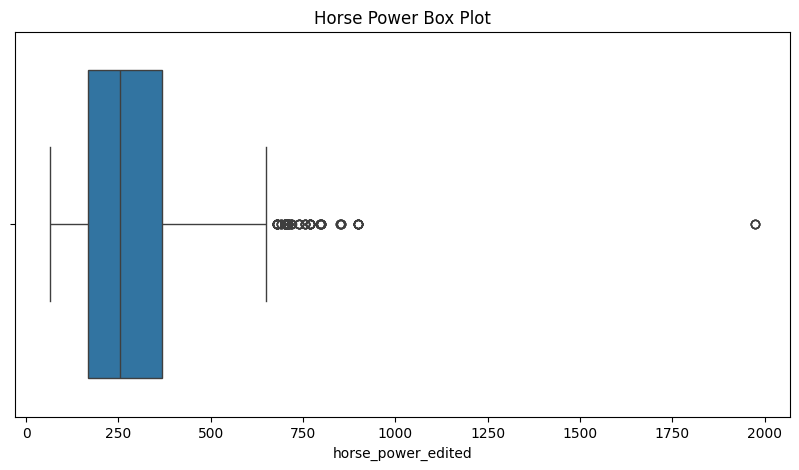

In [ ]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['horse_power_edited'])
plt.title('Horse Power Box Plot')
plt.show()

In [ ]:

car_df.head()

,car name,top_speed,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited
0,Fiat 500e 2021 La Prima,Automatic,150,fiat,ksa,NaN,NaN,NaN,NaN
1,Peugeot Traveller 2021 L3 VIP,8 Seater,8.8,peugeot,ksa,37486.667,2000.0,4.0,180.0
2,Suzuki Jimny 2021 1.5L Automatic,145,4 Seater,suzuki,ksa,26342.667,1500.0,4.0,102.0
3,Ford Bronco 2021 2.3T Big Bend,4 Seater,7.5,ford,ksa,52800.000,2300.0,4.0,420.0
4,Honda HR-V 2021 1.8 i-VTEC LX,190,5 Seater,honda,ksa,NaN,1800.0,4.0,140.0


### Top Speed Column

In [ ]:
top_speeds = []

for speed in car_df['top_speed']:
    try:
        speed = float(speed) # convert to float
        if speed <= 0:
            top_speeds.append(np.nan) # add nan for negative or zero values
        else:
            top_speeds.append(speed)
    except ValueError:
        top_speeds.append(np.nan) # add nan for any error in the conversion

car_df['top_speed_edited'] = top_speeds
car_df.drop('top_speed', axis=1, inplace=True)

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6297 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                6297 non-null   object 
 1   seats                   6297 non-null   object 
 2   brand                   6297 non-null   object 
 3   country                 6297 non-null   object 
 4   price_usd               4969 non-null   float64
 5   engine_capacity_edited  6153 non-null   float64
 6   cylinder_edited         5563 non-null   float64
 7   horse_power_edited      6175 non-null   float64
 8   top_speed_edited        5864 non-null   float64
dtypes: float64(5), object(4)
memory usage: 492.0+ KB


#### Handling Outliers

In [ ]:
car_df['top_speed_edited'].describe()

,top_speed_edited
count,5864.000000
mean,220.876194
std,43.368611
min,120.000000
25%,185.000000
50%,211.000000
75%,250.000000
max,966.000000


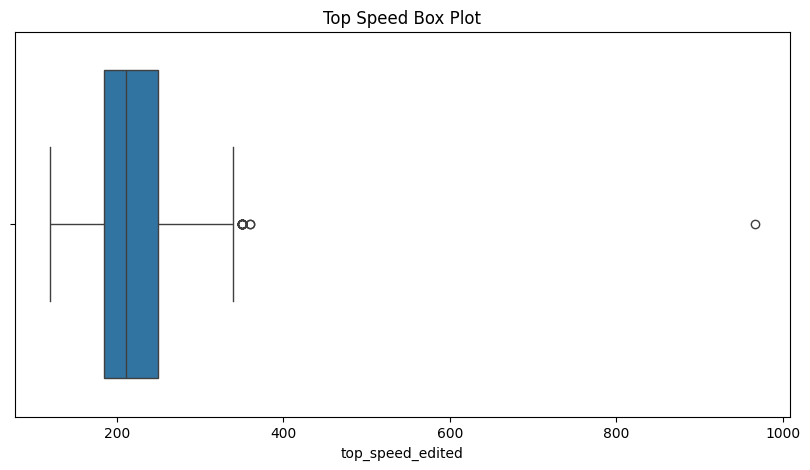

In [ ]:

fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['top_speed_edited'])
plt.title('Top Speed Box Plot')
plt.show()

In [ ]:
#delete the row with top speed > 400
car_df = car_df[(car_df['top_speed_edited'] <= 400) | (car_df['top_speed_edited'].isna())]

In [ ]:

car_df.head()


,car name,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited
0,Fiat 500e 2021 La Prima,150,fiat,ksa,NaN,NaN,NaN,NaN,NaN
1,Peugeot Traveller 2021 L3 VIP,8.8,peugeot,ksa,37486.667,2000.0,4.0,180.0,NaN
2,Suzuki Jimny 2021 1.5L Automatic,4 Seater,suzuki,ksa,26342.667,1500.0,4.0,102.0,145.0
3,Ford Bronco 2021 2.3T Big Bend,7.5,ford,ksa,52800.000,2300.0,4.0,420.0,NaN
4,Honda HR-V 2021 1.8 i-VTEC LX,5 Seater,honda,ksa,NaN,1800.0,4.0,140.0,190.0


### Seats Column

In [ ]:
seats = []

for seat in car_df['seats']:
    try:
        # Try to convert seat directly to an integer
        seat = int(seat)
    except ValueError:
        try:
            # If direct conversion fails, split by space and convert the first part
            seat = int(seat.split(' ')[0])
        except ValueError:
            # If conversion still fails, append NaN
            seats.append(np.nan)
            continue

    # Append NaN if seat is less than or equal to 0, otherwise append the seat value
    if seat <= 0:
        seats.append(np.nan)
    else:
        seats.append(seat)


car_df['seats_edited'] = seats

car_df.drop('seats', axis=1, inplace=True)

<ipython-input-51-496c3e8a3462>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['seats_edited'] = seats
<ipython-input-51-496c3e8a3462>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df.drop('seats', axis=1, inplace=True)


In [ ]:

car_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6296 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                6296 non-null   object 
 1   brand                   6296 non-null   object 
 2   country                 6296 non-null   object 
 3   price_usd               4968 non-null   float64
 4   engine_capacity_edited  6153 non-null   float64
 5   cylinder_edited         5563 non-null   float64
 6   horse_power_edited      6174 non-null   float64
 7   top_speed_edited        5863 non-null   float64
 8   seats_edited            5882 non-null   float64
dtypes: float64(6), object(3)
memory usage: 491.9+ KB


#### Handling Outliers

In [ ]:

car_df['seats_edited'].describe()

,seats_edited
count,5882.000000
mean,7.584665
std,22.496561
min,2.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,260.000000


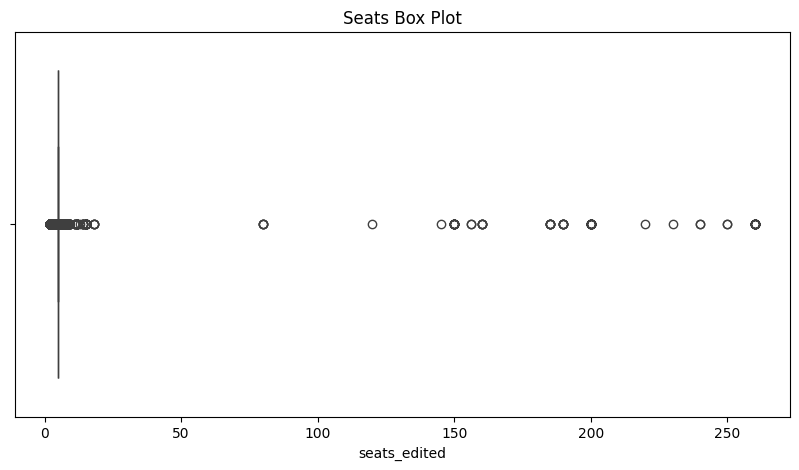

In [ ]:

fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['seats_edited'])
plt.title('Seats Box Plot')
plt.show()

Showing the cars that have more than 10 seats

In [ ]:
#delete records with seats grater that 20
car_df = car_df[(car_df['seats_edited'].isna()) | (car_df['seats_edited'] <= 20)]

In [ ]:
car_df.head()

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
1,Peugeot Traveller 2021 L3 VIP,peugeot,ksa,37486.667,2000.0,4.0,180.0,NaN,NaN
2,Suzuki Jimny 2021 1.5L Automatic,suzuki,ksa,26342.667,1500.0,4.0,102.0,145.0,4.0
3,Ford Bronco 2021 2.3T Big Bend,ford,ksa,52800.000,2300.0,4.0,420.0,NaN,NaN
4,Honda HR-V 2021 1.8 i-VTEC LX,honda,ksa,NaN,1800.0,4.0,140.0,190.0,5.0
5,Honda HR-V 2021 1.8 i-VTEC EX,honda,ksa,25422.667,1800.0,4.0,140.0,190.0,5.0


### Initial  Missing Data Handling

In [ ]:
for i in range(1,car_df.shape[1]):
    print(f"Number of records that have {i} missing values: {car_df[car_df.isna().sum(axis=1) == i].shape[0]}")

Number of records that have 1 missing values: 1643
Number of records that have 2 missing values: 344
Number of records that have 3 missing values: 116
Number of records that have 4 missing values: 21
Number of records that have 5 missing values: 7
Number of records that have 6 missing values: 2
Number of records that have 7 missing values: 0
Number of records that have 8 missing values: 0


In [ ]:
#remove any record that has more than half of features missing values
car_df = car_df[car_df.isna().sum(axis=1) < 4]

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6187 entries, 1 to 6307
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                6187 non-null   object 
 1   brand                   6187 non-null   object 
 2   country                 6187 non-null   object 
 3   price_usd               4942 non-null   float64
 4   engine_capacity_edited  6142 non-null   float64
 5   cylinder_edited         5553 non-null   float64
 6   horse_power_edited      6163 non-null   float64
 7   top_speed_edited        5856 non-null   float64
 8   seats_edited            5787 non-null   float64
dtypes: float64(6), object(3)
memory usage: 483.4+ KB


In [ ]:
for i in range(1,car_df.shape[1]):
    print(f"Number of records that have {i} missing values: {car_df[car_df.isna().sum(axis=1) == i].shape[0]}")

Number of records that have 1 missing values: 1643
Number of records that have 2 missing values: 344
Number of records that have 3 missing values: 116
Number of records that have 4 missing values: 0
Number of records that have 5 missing values: 0
Number of records that have 6 missing values: 0
Number of records that have 7 missing values: 0
Number of records that have 8 missing values: 0


### Encoding Categorical Columns

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6187 entries, 1 to 6307
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                6187 non-null   object 
 1   brand                   6187 non-null   object 
 2   country                 6187 non-null   object 
 3   price_usd               4942 non-null   float64
 4   engine_capacity_edited  6142 non-null   float64
 5   cylinder_edited         5553 non-null   float64
 6   horse_power_edited      6163 non-null   float64
 7   top_speed_edited        5856 non-null   float64
 8   seats_edited            5787 non-null   float64
dtypes: float64(6), object(3)
memory usage: 483.4+ KB


In [ ]:

print(f"Number of unique car name :{car_df['car name'].nunique()}")
print(f"Number of unique brand :{car_df['brand'].nunique()}")
print(f"Number of unique country :{car_df['country'].nunique()}")


Number of unique car name :2501
Number of unique brand :81
Number of unique country :7


In [ ]:
# as shown almost 2-3 cars have the same name so we can drop the car name column
car_df.drop('car name', axis=1, inplace=True)

- number of unique values in **brand column** is **78**, which is too much to be encoded using one hot encoding, so we will use label encoding.
- number of unique values in **coutry column** is **7**, which will be encoded using one hot encoding.

In [ ]:
he = OneHotEncoder(sparse_output=False)
encoded_countries = he.fit_transform(car_df[['country']])

In [ ]:
# Encode the 'brand' column one hot encoding
he = OneHotEncoder(sparse_output=False)
encoded_countries = he.fit_transform(car_df[['country']])


# Convert the result to a DataFrame
encoded_countries_df = pd.DataFrame(
    encoded_countries,
    columns=he.get_feature_names_out(['country'])
)
# Set the index of the encoded DataFrame to be the same as the original DataFrame
encoded_countries_df.index = car_df.index

# Combine the original DataFrame with the one-hot encoded DataFrame
car_df = pd.concat([car_df, encoded_countries_df], axis=1)

# Drop the 'country' column
car_df.drop('country', axis=1, inplace=True)


# Create an instance of the LabelEncoder
le = LabelEncoder()
# Encode the 'brand' column
car_df['brand_encoded'] = le.fit_transform(car_df['brand'])





In [ ]:
car_df.head()

,brand,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae,brand_encoded
1,peugeot,37486.667,2000.0,4.0,180.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61
2,suzuki,26342.667,1500.0,4.0,102.0,145.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,73
3,ford,52800.000,2300.0,4.0,420.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25
4,honda,NaN,1800.0,4.0,140.0,190.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,32
5,honda,25422.667,1800.0,4.0,140.0,190.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,32


In [ ]:
#drop the brand column
car_df.drop('brand', axis=1, inplace=True)

In [ ]:
car_df.head()

,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae,brand_encoded
1,37486.667,2000.0,4.0,180.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61
2,26342.667,1500.0,4.0,102.0,145.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,73
3,52800.000,2300.0,4.0,420.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25
4,NaN,1800.0,4.0,140.0,190.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,32
5,25422.667,1800.0,4.0,140.0,190.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,32


In [ ]:
car_df.describe()

,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae,brand_encoded
count,4.942000e+03,6142.000000,5553.000000,6163.000000,5856.000000,5787.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000,6187.000000
mean,7.085535e+04,2879.152719,5.386638,290.349181,220.761954,5.043546,0.144335,0.062551,0.156942,0.148861,0.144497,0.147083,0.195733,41.030063
std,9.395732e+04,1310.198027,1.871449,156.434727,42.236737,1.570171,0.351457,0.242172,0.363775,0.355980,0.351621,0.354217,0.396796,22.222243
min,4.765056e+03,999.000000,3.000000,65.000000,120.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.558784e+04,2000.000000,4.000000,168.000000,185.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000
50%,4.722915e+04,2500.000000,4.000000,255.000000,211.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000
75%,8.225723e+04,3600.000000,6.000000,367.000000,250.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
max,2.200604e+06,6800.000000,12.000000,1973.000000,360.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000


### Handling Missing Values

In [ ]:
print("number of missing data in each feature")
car_df.isna().sum()

number of missing data in each feature


,0
price_usd,1245
engine_capacity_edited,45
cylinder_edited,634
horse_power_edited,24
top_speed_edited,331
seats_edited,400
country_bahrain,0
country_egypt,0
country_ksa,0
country_kuwait,0


- **Correlation** between features will be utilized to impute missing values

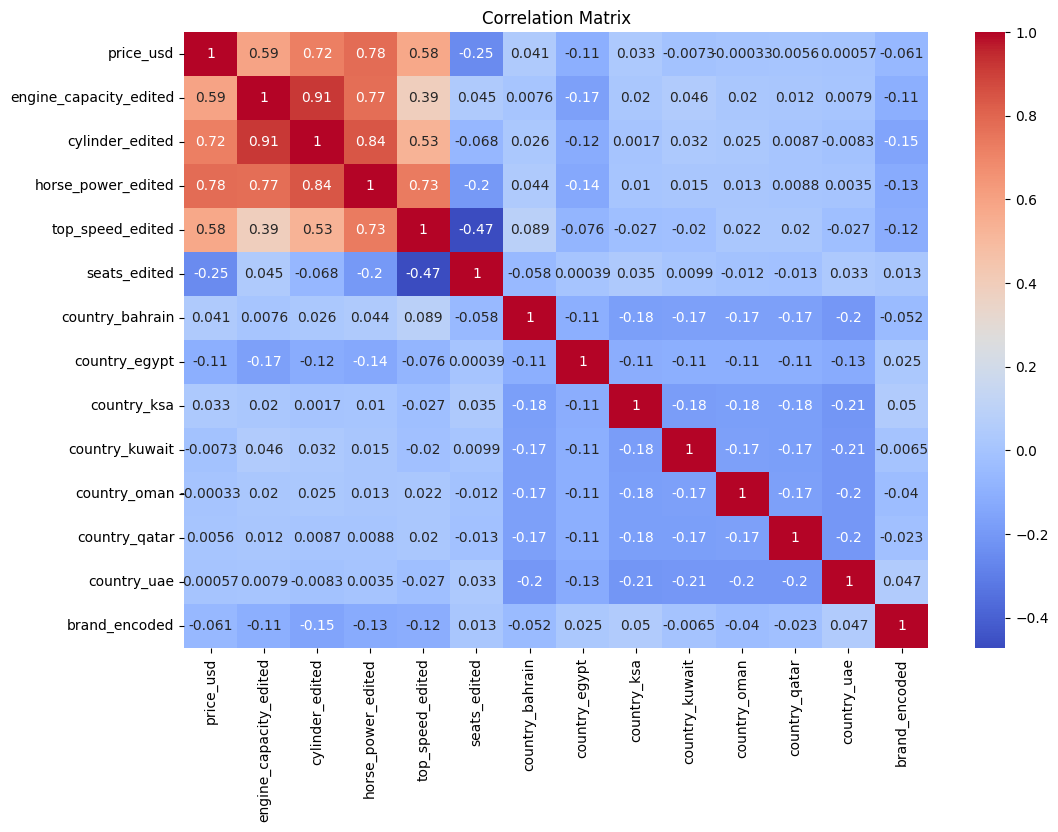

In [ ]:
# make correlation matrix
corr = car_df.corr()

# plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Top Speed Column

top speed is highly correlated with horsepower, so we will use horsepower to impute missing values in top speed.

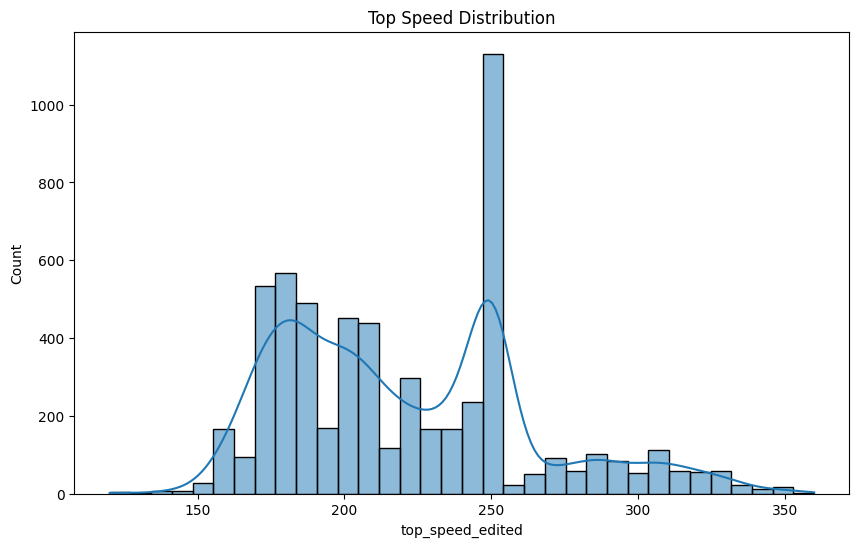

In [ ]:
# draw histogram for top speed
plt.figure(figsize=(10, 6))
sns.histplot(car_df['top_speed_edited'], kde=True)
plt.title('Top Speed Distribution')
plt.show()

In [ ]:
# create 10 bins based on the range of horse_power_edited
#Creates bins of equal width based on the range of the data.
# Create 10 bins for horse_power_edited
horse_power_bins = pd.cut(car_df['horse_power_edited'], bins=10, include_lowest=True)

# Fill missing values in top_speed_edited based on the mean within each horse power range
car_df['top_speed_edited'] = car_df['top_speed_edited'].fillna(
    car_df.groupby(horse_power_bins)['top_speed_edited'].transform('mean')
)



<ipython-input-73-119510066da1>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  car_df.groupby(horse_power_bins)['top_speed_edited'].transform('mean')


In [ ]:
car_df.isna().sum()


,0
price_usd,1245
engine_capacity_edited,45
cylinder_edited,634
horse_power_edited,24
top_speed_edited,30
seats_edited,400
country_bahrain,0
country_egypt,0
country_ksa,0
country_kuwait,0


In [ ]:
car_df['top_speed_edited'].fillna(car_df['top_speed_edited'].mean(), inplace=True) # fill the remaining missing values with the mean

<ipython-input-75-c1d438b5e918>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_df['top_speed_edited'].fillna(car_df['top_speed_edited'].mean(), inplace=True) # fill the remaining missing values with the mean


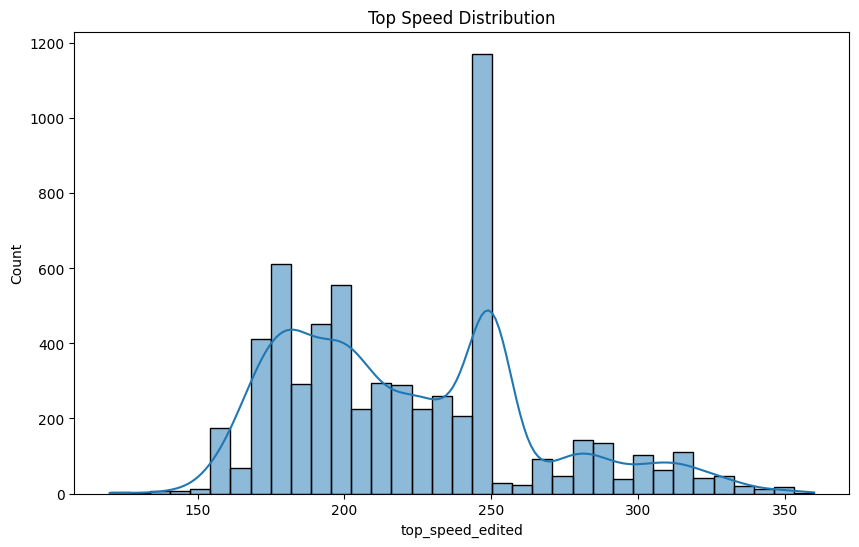

In [ ]:

# draw histogram for top speed
plt.figure(figsize=(10, 6))
sns.histplot(car_df['top_speed_edited'], kde=True)
plt.title('Top Speed Distribution')
plt.show()


#### Cylinder Column

cyliners is highly correlated with engine capacity, so we will use engine capacity to impute missing values in cyliners.

In [ ]:
# # fill the missing values with the mode of the cylinder for the same engine capacity
# car_df['cylinder_edited'] = car_df['cylinder_edited'].fillna(
#     car_df.groupby('engine_capacity_edited')['cylinder_edited'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
# )

engine_capacity_bins = pd.cut(car_df['engine_capacity_edited'], bins=10, include_lowest=True)

# Fill missing values in cylinder_edited based on the mode within each engine capacity range
car_df['cylinder_edited'] = car_df['cylinder_edited'].fillna(
    car_df.groupby(engine_capacity_bins)['cylinder_edited'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)



<ipython-input-122-912e5db9dd36>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  car_df.groupby(engine_capacity_bins)['cylinder_edited'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)


In [ ]:
car_df.isna().sum()

,0
price_usd,1245
engine_capacity_edited,45
cylinder_edited,634
horse_power_edited,24
top_speed_edited,0
seats_edited,400
country_bahrain,0
country_egypt,0
country_ksa,0
country_kuwait,0


In [ ]:
 # fill the remaining missing values with the mode
car_df['cylinder_edited'].fillna(car_df['cylinder_edited'].mode()[0], inplace=True)

<ipython-input-78-89062d4ce84b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_df['cylinder_edited'].fillna(car_df['cylinder_edited'].mode()[0], inplace=True)


In [ ]:
car_df.isna().sum()

,0
price_usd,1245
engine_capacity_edited,45
cylinder_edited,0
horse_power_edited,24
top_speed_edited,0
seats_edited,400
country_bahrain,0
country_egypt,0
country_ksa,0
country_kuwait,0


#### Seats Column

seats not highly correlated with any other feature so impute with mode

In [ ]:

car_df['seats_edited'] = car_df['seats_edited'].fillna(car_df['seats_edited'].mode()[0]) # fill the missing values with the mode

In [ ]:
car_df.isna().sum()


,0
price_usd,1245
engine_capacity_edited,45
cylinder_edited,0
horse_power_edited,24
top_speed_edited,0
seats_edited,0
country_bahrain,0
country_egypt,0
country_ksa,0
country_kuwait,0


#### Horsepower and Engine Capacity Column

In [ ]:
# portion of the data that hae missimg horse_power_edited , engine_capacity_edited
missing_data = car_df[(car_df['horse_power_edited'].isna()) | (car_df['engine_capacity_edited'].isna())]

print(f"Number of records that have missing values in horse_power_edited or engine_capacity_edited: {missing_data.shape[0]}")
print(f"Percentage of records that have missing values in horse_power_edited or engine_capacity_edited: {missing_data.shape[0] / car_df.shape[0] * 100:.2f}%")


Number of records that have missing values in horse_power_edited or engine_capacity_edited: 62
Percentage of records that have missing values in horse_power_edited or engine_capacity_edited: 1.00%


percentage is small so we will remove the rows with missing values

In [ ]:

# drop the records that have missing values in horse_power_edited or engine_capacity_edited
car_df = car_df.dropna(subset=['horse_power_edited', 'engine_capacity_edited'])



In [ ]:
car_df.isna().sum()

,0
price_usd,1216
engine_capacity_edited,0
cylinder_edited,0
horse_power_edited,0
top_speed_edited,0
seats_edited,0
country_bahrain,0
country_egypt,0
country_ksa,0
country_kuwait,0


#### Price Column

price is highly correlated with hourspower, so we will use this feature to impute missing values in price.

In [ ]:
house_power_bins = pd.cut(car_df['horse_power_edited'], bins=10, include_lowest=True)

# Fill missing values in price_usd based on the mean within each horse power range
car_df['price_usd'] = car_df['price_usd'].fillna(
    car_df.groupby(house_power_bins)['price_usd'].transform('mean')
)



<ipython-input-85-bff5c144e2cb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  car_df.groupby(house_power_bins)['price_usd'].transform('mean')


In [ ]:
car_df.isna().sum()

,0
price_usd,0
engine_capacity_edited,0
cylinder_edited,0
horse_power_edited,0
top_speed_edited,0
seats_edited,0
country_bahrain,0
country_egypt,0
country_ksa,0
country_kuwait,0


In [ ]:
print(f"percentage of deleted records: {100 - car_df.shape[0] / original_shape[0] * 100:.2f}%")

percentage of deleted records: 2.90%


In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6125 entries, 1 to 6307
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price_usd               6125 non-null   float64
 1   engine_capacity_edited  6125 non-null   float64
 2   cylinder_edited         6125 non-null   float64
 3   horse_power_edited      6125 non-null   float64
 4   top_speed_edited        6125 non-null   float64
 5   seats_edited            6125 non-null   float64
 6   country_bahrain         6125 non-null   float64
 7   country_egypt           6125 non-null   float64
 8   country_ksa             6125 non-null   float64
 9   country_kuwait          6125 non-null   float64
 10  country_oman            6125 non-null   float64
 11  country_qatar           6125 non-null   float64
 12  country_uae             6125 non-null   float64
 13  brand_encoded           6125 non-null   int64  
dtypes: float64(13), int64(1)
memory usage: 717.8 

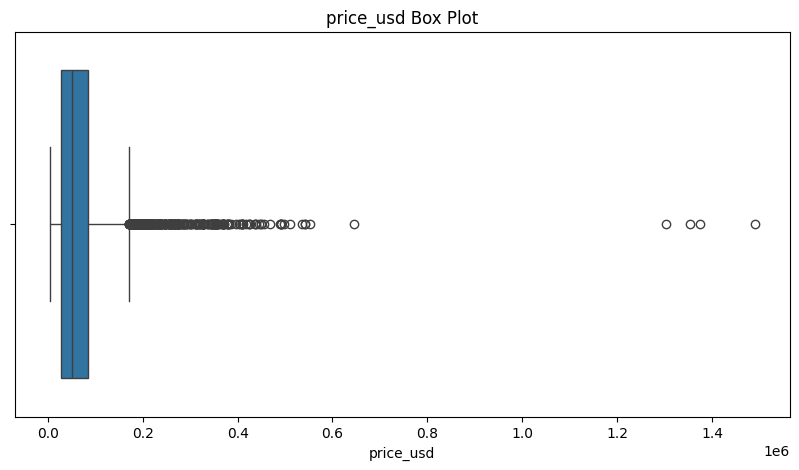

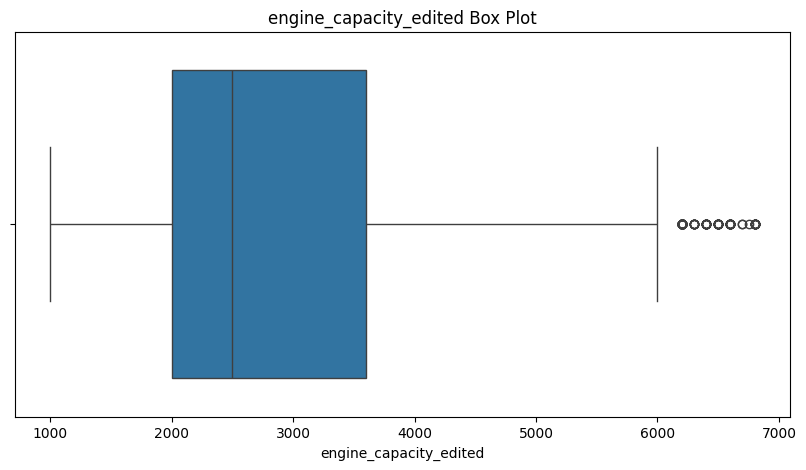

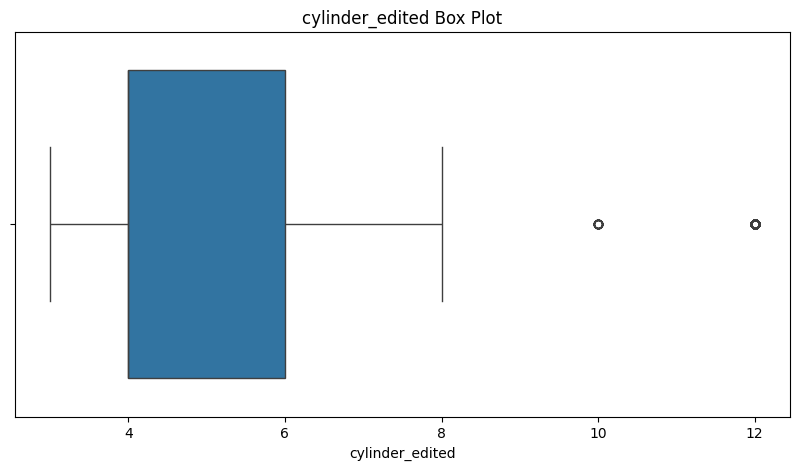

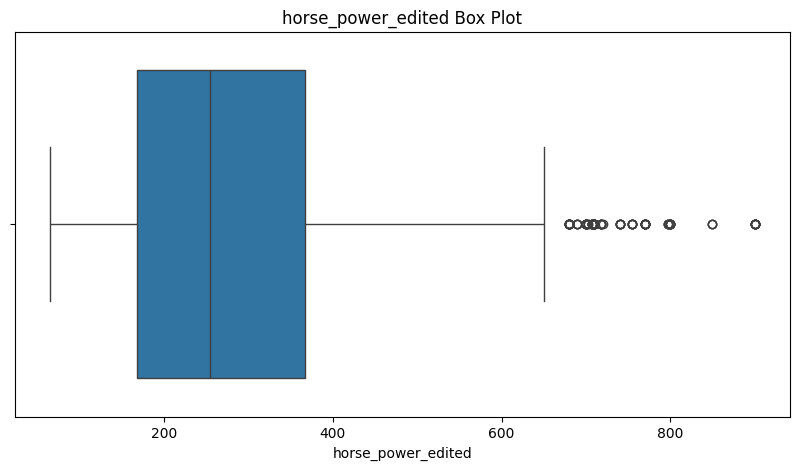

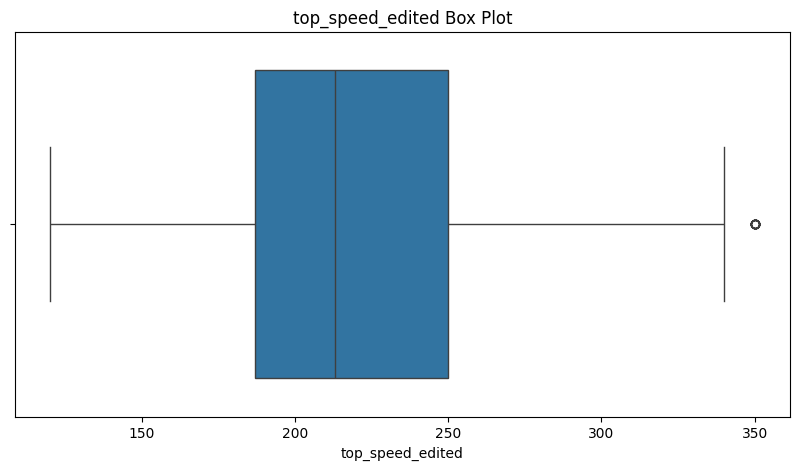

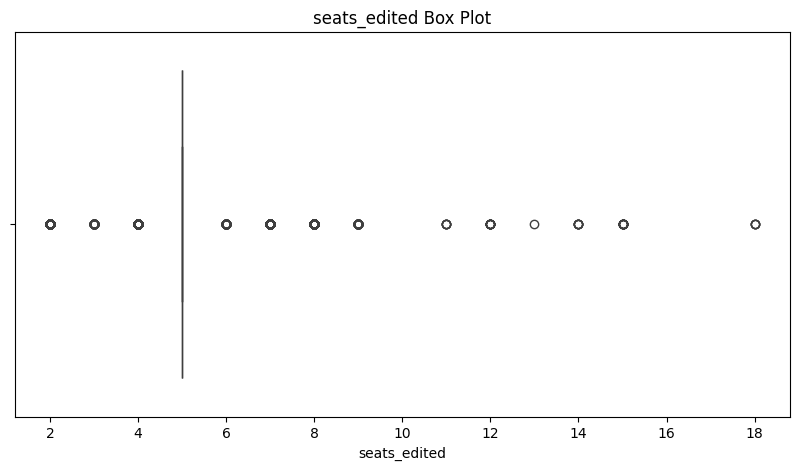

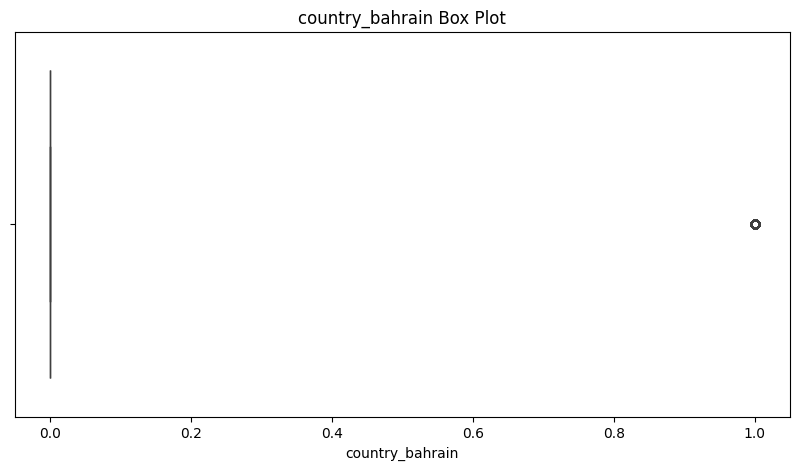

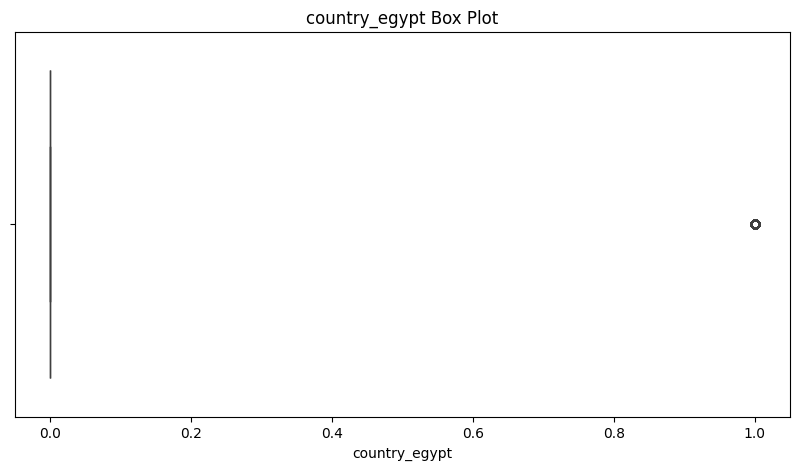

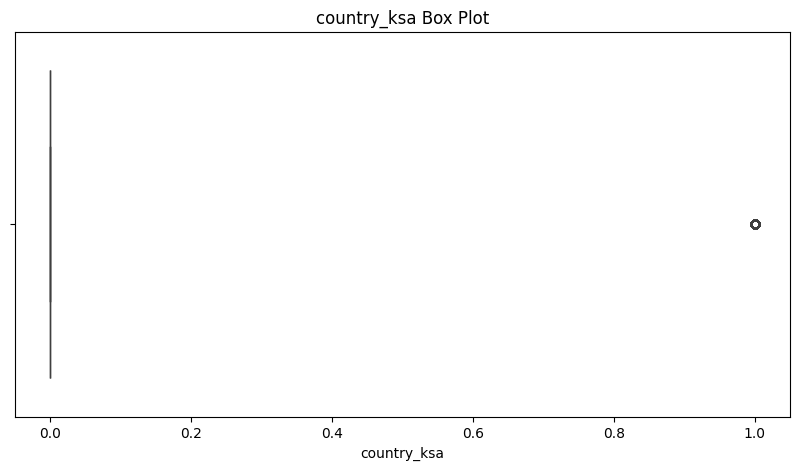

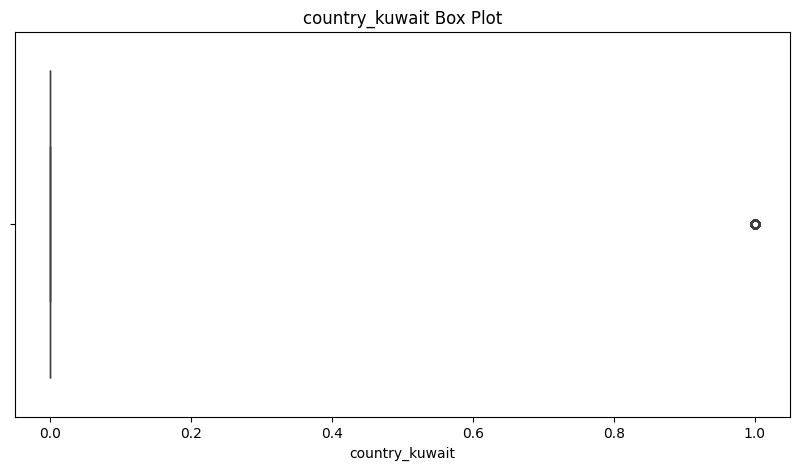

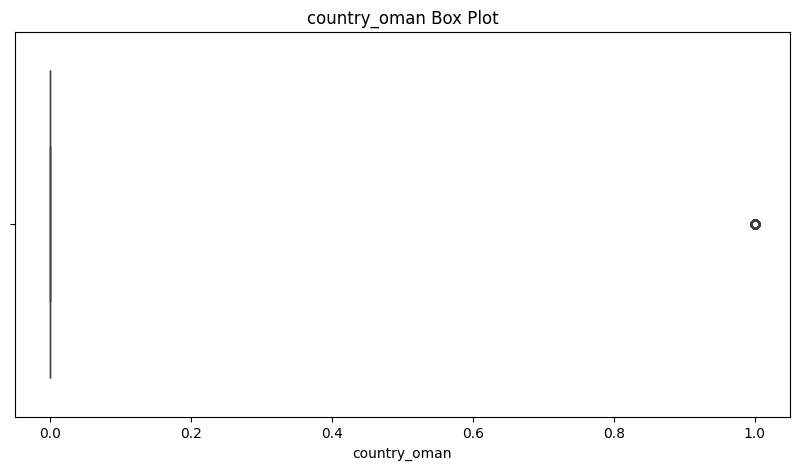

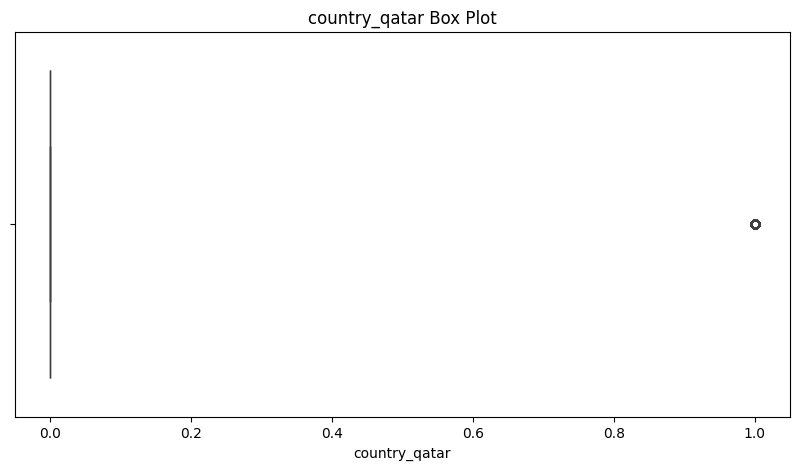

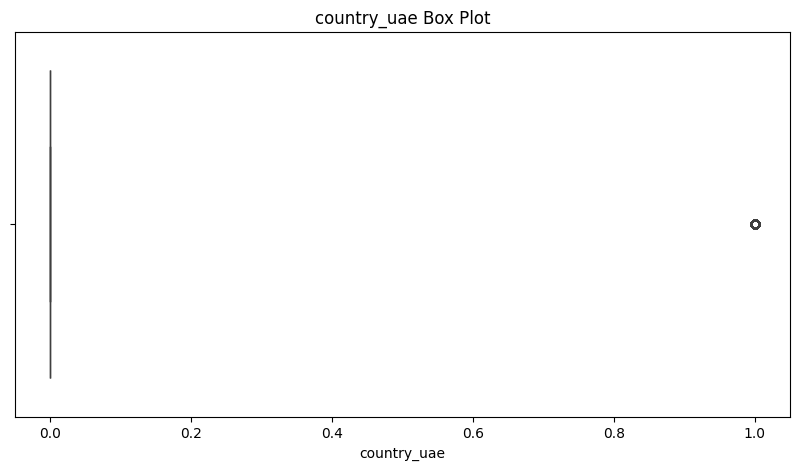

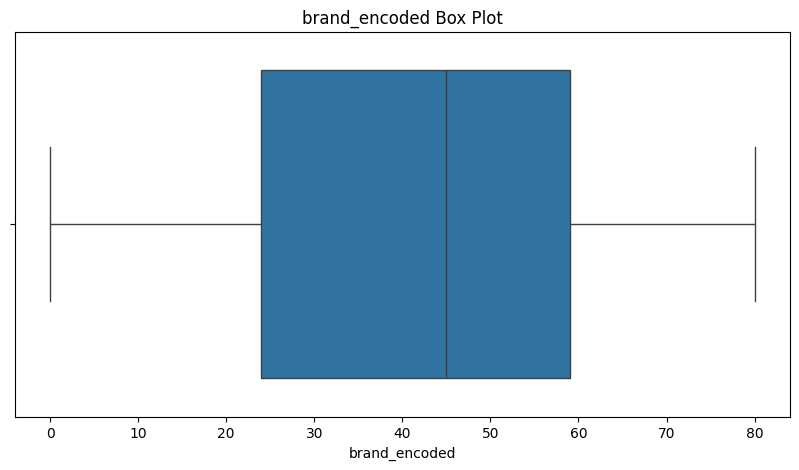

In [ ]:
# @draw box plot for each numaric feature
for col in car_df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=car_df[col])
    plt.title(f'{col} Box Plot')
    plt.show()

### Normalizing the Data

In [ ]:
# make z score for scaling the data

# store the mean and that standard deviation of the price_usd column
price_mean = car_df['price_usd'].mean()
price_std = car_df['price_usd'].std()

car_df_scaled = car_df.apply(zscore)

car_df_scaled.head()

,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae,brand_encoded
1,-0.449410,-0.671732,-0.685566,-0.724831,-0.542226,-0.025328,-0.410695,-0.259344,2.323835,-0.418806,-0.41178,-0.416379,-0.491311,0.907714
2,-0.598518,-1.053011,-0.685566,-1.244119,-1.819977,-0.682672,-0.410695,-0.259344,2.323835,-0.418806,-0.41178,-0.416379,-0.491311,1.448748
3,-0.244517,-0.442964,-0.685566,0.872977,0.125259,-0.025328,-0.410695,-0.259344,2.323835,-0.418806,-0.41178,-0.416379,-0.491311,-0.715386
4,-0.697204,-0.824244,-0.685566,-0.991132,-0.746538,-0.025328,-0.410695,-0.259344,2.323835,-0.418806,-0.41178,-0.416379,-0.491311,-0.399783
5,-0.610828,-0.824244,-0.685566,-0.991132,-0.746538,-0.025328,-0.410695,-0.259344,2.323835,-0.418806,-0.41178,-0.416379,-0.491311,-0.399783


In [ ]:
car_df_scaled.describe()

,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae,brand_encoded
count,6.125000e+03,6.125000e+03,6.125000e+03,6.125000e+03,6.125000e+03,6.125000e+03,6.125000e+03,6.125000e+03,6125.000000,6.125000e+03,6125.000000,6.125000e+03,6.125000e+03,6.125000e+03
mean,9.280558e-18,-4.640279e-17,-1.856112e-17,-8.816530e-17,5.104307e-17,-1.136868e-16,-1.113667e-16,9.280558e-17,0.000000,-7.424447e-17,0.000000,-7.424447e-17,-7.424447e-17,-4.408265e-17
std,1.000082e+00,1.000082e+00,1.000082e+00,1.000082e+00,1.000082e+00,1.000082e+00,1.000082e+00,1.000082e+00,1.000082,1.000082e+00,1.000082,1.000082e+00,1.000082e+00,1.000082e+00
min,-8.872283e-01,-1.435054e+00,-1.233750e+00,-1.490447e+00,-2.416333e+00,-1.997361e+00,-4.106947e-01,-2.593436e-01,-0.430323,-4.188057e-01,-0.411780,-4.163792e-01,-4.913108e-01,-1.842540e+00
25%,-5.887821e-01,-6.717317e-01,-6.855656e-01,-8.047213e-01,-8.181006e-01,-2.532788e-02,-4.106947e-01,-2.593436e-01,-0.430323,-4.188057e-01,-0.411780,-4.163792e-01,-4.913108e-01,-7.604724e-01
50%,-2.602600e-01,-2.904520e-01,-6.855656e-01,-2.255159e-01,-1.978911e-01,-2.532788e-02,-4.106947e-01,-2.593436e-01,-0.430323,-4.188057e-01,-0.411780,-4.163792e-01,-4.913108e-01,1.863364e-01
75%,1.811759e-01,5.483632e-01,4.108024e-01,5.201278e-01,6.847147e-01,-2.532788e-02,-4.106947e-01,-2.593436e-01,-0.430323,-4.188057e-01,-0.411780,-4.163792e-01,-4.913108e-01,8.175422e-01
max,1.898236e+01,2.988553e+00,3.699906e+00,4.068593e+00,3.070136e+00,8.520149e+00,2.434899e+00,3.855888e+00,2.323835,2.387742e+00,2.428482,2.401657e+00,2.035372e+00,1.764351e+00


### Splitting the Data into Training, Validation and Testing Sets

In [ ]:

def split_data(df, target_column, val_size=0.2, test_size=0.2):
    train_size = 1 - val_size - test_size
    # Split the dataset into features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split the dataset into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    val_size = val_size / (train_size + val_size)  # Calculate the relative size of the validation set

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


## Traininig the Models

In [ ]:
r2_scores = {} # store the r2 scores on validation set of the models

### Linear Regression

#### Closed Form Solution

In [ ]:
# make regrission model with closed form solution (XT X)-1 XT y
def closed_form_solution(X, y):
    X_T = X.T
    X_T_dot_X = X_T.dot(X)
    # Use pseudo-inverse instead of explicit inversion
    X_T_dot_X_inv = np.linalg.pinv(X_T_dot_X)
    X_T_dot_y = X_T.dot(y)
    return X_T_dot_X_inv.dot(X_T_dot_y)

# make prediction
def predict(X, w):
    return w.transpose().dot(X)

# make R score for evaluation
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    SS_res = np.sum((y_true - y_pred) ** 2)
    SS_tot = np.sum((y_true - y_mean) ** 2)
    return 1 - (SS_res / SS_tot)


- Scaled Data

In [ ]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

w = closed_form_solution(X_train, y_train)
for i in range(X_train.shape[1]):
    print(f'w{i} = {w[i]}')

print('\n=======================================\n')

y_pred = X_val.dot(w)
r2_closed_linear_scaled = r_squared(y_val, y_pred)
print(f'R^2: {r2_closed_linear_scaled}')

r2_scores['Closed Form Linear Regression Scaled'] = r2_closed_linear_scaled

w0 = -0.23725302999550094
w1 = 0.3216313510433607
w2 = 0.6762155881587238
w3 = 0.052800607970279495
w4 = -0.049106271442436025
w5 = -0.004269799146976194
w6 = -0.012660144820752435
w7 = 0.03401368137114631
w8 = -0.007764849565426215
w9 = -0.012383058958748513
w10 = -0.0049939638083270725
w11 = 0.002844116330304756
w12 = 0.016361844633390413


R^2: 0.7814797875318658


- Unscaled Data

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df, 'price_usd')

w = closed_form_solution(X_train, y_train)
for i in range(X_train.shape[1]):
    print(f'w{i} = {w[i]}')

print('\n=======================================\n')

y_pred = X_val.dot(w)
r2_closed_linear_unscaled = r_squared(y_val, y_pred)
print(f'R^2: {r2_closed_linear_unscaled}')

r2_scores['Closed Form Linear Regression Unscaled'] = r2_closed_linear_unscaled

w0 = -13.517664640187572
w1 = 13175.258005991136
w2 = 336.4259558347068
w3 = 94.40739739666952
w4 = -2404.5959126271273
w5 = -68749.78162217309
w6 = -71768.65641535942
w7 = -60874.90552699759
w8 = -69487.85192782198
w9 = -70490.6722789635
w10 = -68897.86946429382
w11 = -67326.00434683905
w12 = 55.19001458818867


R^2: 0.781661086721267


#### Gradient Descent Solution (API)

- Scaled Data

In [ ]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

#use sklearn linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
r2_api_linear_scaled = r2_score(y_val, y_pred)
print(f'R^2: {r2_api_linear_scaled}')

r2_scores['API Linear Regression Scaled'] = r2_api_linear_scaled


R^2: 0.7816610867212661


- Unscaled Data

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df, 'price_usd')

#use sklearn linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
r2_api_linear_unscaled = r2_score(y_val, y_pred)
print(f'R^2: {r2_api_linear_unscaled}')

r2_scores['API Linear Regression Unscaled'] = r2_api_linear_unscaled


R^2: 0.7816610867212641


#### Scaled vs Unscaled Data

In [ ]:
# make a comparison between the scaled and unscaled data
print(f'R^2 closed form solution (scaled): {r2_closed_linear_scaled}')
print(f'R^2 closed form solution (unscaled): {r2_closed_linear_unscaled}')
print(f'R^2 API (scaled): {r2_api_linear_scaled}')
print(f'R^2 API (unscaled): {r2_api_linear_unscaled}')

print('\n=======================================\n')


sorted_r2_scores = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)
print('R^2 scores:')
for model, r2 in sorted_r2_scores:
    print(f'{model}: {r2}')

R^2 closed form solution (scaled): 0.7814797875318658
R^2 closed form solution (unscaled): 0.781661086721267
R^2 API (scaled): 0.7816610867212661
R^2 API (unscaled): 0.7816610867212641


R^2 scores:
Closed Form Linear Regression Unscaled: 0.781661086721267
API Linear Regression Scaled: 0.7816610867212661
API Linear Regression Unscaled: 0.7816610867212641
Closed Form Linear Regression Scaled: 0.7814797875318658



there is no noticable difference between the scaled and unscaled data in the r2 score.

Scaled Data will be used in the next models.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

### Regularization

#### Lasso Regression

- Use grid search to find the best alpha value

In [ ]:

# Create the Lasso model
lasso = Lasso()

# Create the parameter grid
labda= [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'alpha': labda}

# Create the GridSearchCV object
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')


# Fit the model

 # use the entire dataset without the testing set because GridSearchCV uses cross-validation
#concate the training and validation set df
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
grid_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
grid_search.best_params_




{'alpha': 0.001}

In [ ]:
df = pd.DataFrame(grid_search.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008397,0.001870,0.002938,0.000225,0.001,{'alpha': 0.001},0.531953,0.758761,0.794146,0.759520,0.798263,0.728529,0.099684,1
1,0.009838,0.003388,0.004479,0.002773,0.010,{'alpha': 0.01},0.525615,0.760314,0.795086,0.758438,0.794057,0.726702,0.101771,2
2,0.005359,0.000056,0.003067,0.000406,0.100,{'alpha': 0.1},0.492208,0.730715,0.769088,0.728081,0.764761,0.696970,0.103760,3
3,0.004432,0.000084,0.002807,0.000049,1.000,{'alpha': 1},-0.000006,-0.000996,-0.002229,-0.000397,-0.001215,-0.000969,0.000762,4
4,0.004685,0.000550,0.002994,0.000287,10.000,{'alpha': 10},-0.000006,-0.000996,-0.002229,-0.000397,-0.001215,-0.000969,0.000762,4
5,0.004419,0.000361,0.003951,0.002429,100.000,{'alpha': 100},-0.000006,-0.000996,-0.002229,-0.000397,-0.001215,-0.000969,0.000762,4
6,0.004324,0.000083,0.002713,0.000053,1000.000,{'alpha': 1000},-0.000006,-0.000996,-0.002229,-0.000397,-0.001215,-0.000969,0.000762,4


- Use the best alpha value to train the model

In [ ]:
# Create the Lasso model with the best hyperparameters
lasso = Lasso(alpha=grid_search.best_params_['alpha'])
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)
r2_lasso = r2_score(y_val, y_pred)

print(f'R^2 Lasso: {r2_lasso}')

r2_scores['lasso'] = r2_lasso

R^2 Lasso: 0.7813217771183482


#### Ridge Regression

- Use grid search to find the best alpha value

In [ ]:

# Create the Ridge model
ridge = Ridge()

# Create the parameter grid
labda = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = {'alpha': labda}

# Create the GridSearchCV object
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')

# Fit the model
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
grid_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
grid_search.best_params_



{'alpha': 10}

In [ ]:

df = pd.DataFrame(grid_search.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006339,0.003743,0.003361,0.001050,0.001,{'alpha': 0.001},0.532466,0.758323,0.793689,0.759361,0.798463,0.728460,0.099414,5
1,0.004839,0.000374,0.003466,0.001192,0.010,{'alpha': 0.01},0.532465,0.758324,0.793689,0.759362,0.798463,0.728461,0.099414,4
2,0.004548,0.000142,0.002787,0.000089,0.100,{'alpha': 0.1},0.532460,0.758327,0.793692,0.759365,0.798464,0.728462,0.099417,3
3,0.005225,0.000908,0.002877,0.000122,1.000,{'alpha': 1},0.532404,0.758364,0.793725,0.759395,0.798469,0.728471,0.099448,2
4,0.006289,0.002934,0.003054,0.000142,10.000,{'alpha': 10},0.531848,0.758693,0.794012,0.759666,0.798489,0.728542,0.099745,1
5,0.004730,0.000166,0.003016,0.000188,100.000,{'alpha': 100},0.526400,0.759617,0.794159,0.760009,0.796671,0.727371,0.101743,6
6,0.004983,0.000430,0.003520,0.001067,1000.000,{'alpha': 1000},0.495016,0.739237,0.771281,0.738319,0.768592,0.702489,0.104672,7


- Train the model using the best alpha value

In [ ]:

# Create the Ridge model with the best hyperparameters
ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)

r2_ridge = r2_score(y_val, y_pred)

print(f'R^2 Ridge: {r2_ridge}')

r2_scores['ridge'] = r2_ridge


R^2 Ridge: 0.7816593768014156


### Polynomial Regression

In [ ]:

r2_scores_temp = {}
for degree in range(2, 5):

    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)


    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)

    y_val_pred = lr_poly.predict(X_val_poly)

    r2 = r2_score(y_val, y_val_pred)
    r2_scores_temp[degree] = r2
    print(f"Degree: {degree}, R^2: {r2:.4f}")

best_degree = max(r2_scores_temp, key=r2_scores_temp.get)
r2_scores[f'polynomial_regression_degree_{best_degree}'] = r2_scores_temp[best_degree]
print(f"Best polynomial degree: {best_degree} with R^2: {r2_scores_temp[best_degree]:.4f}")

r2_scores[f'polynomial_regression_degree_{best_degree}_with_all'] = r2_scores_temp[best_degree]

Degree: 2, R^2: 0.8398
Degree: 3, R^2: 0.7733
Degree: 4, R^2: -1.2238
Best polynomial degree: 2 with R^2: 0.8398


- it takes a lot of time to run the polynomial regression with degree 4 and r2 score is getting worse
- a soulution to test degree from 2 to 10 is to reduce number of features by taking top 3 highly correlated features with the target variable

In [ ]:
top_corr_features_with_price = ['cylinder_edited',
                                'horse_power_edited', 'top_speed_edited']

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled[top_corr_features_with_price + ['price_usd']], 'price_usd')

r2_scores_temp = {}
for degree in range(2, 11):

    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)


    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)

    y_val_pred = lr_poly.predict(X_val_poly)

    r2 = r2_score(y_val, y_val_pred)
    r2_scores_temp[degree] = r2
    print(f"Degree: {degree}, R^2: {r2:.4f}")

best_degree = max(r2_scores_temp, key=r2_scores_temp.get)

print(f"Best polynomial degree: {best_degree} with R^2: {r2_scores_temp[best_degree]:.4f}")

r2_scores[f'polynomial_regression_degree_{best_degree}_with_top_corr_features'] = r2_scores_temp[best_degree]

Degree: 2, R^2: 0.8170
Degree: 3, R^2: 0.8079
Degree: 4, R^2: 0.7884
Degree: 5, R^2: 0.7752
Degree: 6, R^2: 0.7369
Degree: 7, R^2: 0.6189
Degree: 8, R^2: -0.2244
Degree: 9, R^2: -1338.4410
Degree: 10, R^2: -1178253986.9807
Best polynomial degree: 2 with R^2: 0.8170


### Radial Basis Function (RBF)

In [ ]:

def radial_basis_function(X, centers, gamma):
    n_samples = X.shape[0]
    n_centers = centers.shape[0]
    X_rbf = np.ones((n_samples, 1))

    for i in range(n_centers):
        center = centers[i]
        rbf = np.exp(-gamma * np.linalg.norm(X - center, axis=1) ** 2).reshape(-1, 1)
        X_rbf = np.hstack((X_rbf, rbf))

    print(f'X_rbf shape: {X_rbf.shape}')
    return X_rbf


In [ ]:
centers = X_train.sample(n=10, random_state=42).values

X_train_rbf = radial_basis_function(X_train, centers, 1)



X_rbf shape: (3675, 11)


In [ ]:


X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

r2_rbf = []
for gamma in [0.01, 0.1, 1, 10, 100]:
    for n_centers in [10, 20, 30, 40, 50]:
        centers = X_train.sample(n=n_centers, random_state=42).values

        X_train_rbf = radial_basis_function(X_train, centers, gamma)

        lr_rbf = LinearRegression()
        lr_rbf.fit(X_train_rbf, y_train)

        y_pred = lr_rbf.predict(radial_basis_function(X_val, centers, gamma))


        r2 = r2_score(y_val, y_pred)
        r2_rbf.append((gamma, n_centers, r2))

        print(f"Gamma: {gamma}, Number of centers: {n_centers}")
        print(f"R^2: {r2:.4f}\n")

best_combination = max(r2_rbf, key=lambda x: x[2])
r2_scores[f'RBF(Gamma={best_combination[0]}, N_Centers={best_combination[1]})'] = best_combination[2]
print(f"Best Gamma: {best_combination[0]}, Best Number of Centers: {best_combination[1]}, Best R^2: {best_combination[2]:.4f}")



X_rbf shape: (3675, 11)
X_rbf shape: (1225, 11)
Gamma: 0.01, Number of centers: 10
R^2: 0.7814

X_rbf shape: (3675, 21)
X_rbf shape: (1225, 21)
Gamma: 0.01, Number of centers: 20
R^2: 0.8057

X_rbf shape: (3675, 31)
X_rbf shape: (1225, 31)
Gamma: 0.01, Number of centers: 30
R^2: 0.8214

X_rbf shape: (3675, 41)
X_rbf shape: (1225, 41)
Gamma: 0.01, Number of centers: 40
R^2: 0.8337

X_rbf shape: (3675, 51)
X_rbf shape: (1225, 51)
Gamma: 0.01, Number of centers: 50
R^2: 0.8346

X_rbf shape: (3675, 11)
X_rbf shape: (1225, 11)
Gamma: 0.1, Number of centers: 10
R^2: 0.5288

X_rbf shape: (3675, 21)
X_rbf shape: (1225, 21)
Gamma: 0.1, Number of centers: 20
R^2: 0.6086

X_rbf shape: (3675, 31)
X_rbf shape: (1225, 31)
Gamma: 0.1, Number of centers: 30
R^2: 0.6465

X_rbf shape: (3675, 41)
X_rbf shape: (1225, 41)
Gamma: 0.1, Number of centers: 40
R^2: 0.6680

X_rbf shape: (3675, 51)
X_rbf shape: (1225, 51)
Gamma: 0.1, Number of centers: 50
R^2: 0.6994

X_rbf shape: (3675, 11)
X_rbf shape: (1225, 1

### Forward Selection

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

def forward_selection(X_train, X_val, y_train, y_val, max_features=None, min_improvement=0.001):
    selected_features = []
    remaining_features = list(range(X_train.shape[1]))
    best_r2 = -np.inf
    feature_scores = []



    y_pred = np.full(y_val.shape, np.mean(y_train))

    current_best_r2 = r2_score(y_val, y_pred)
    best_r2 = current_best_r2
    # feature_scores.append((None, current_best_r2))


    while remaining_features:
        best_feature = None


        for feature in remaining_features:

            features_to_test = selected_features + [feature]
            X_train_subset = X_train[:, features_to_test]
            X_val_subset = X_val[:, features_to_test]

            model = LinearRegression()
            model.fit(X_train_subset, y_train)
            y_val_pred = model.predict(X_val_subset)

            r2 = r2_score(y_val, y_val_pred)

            # print(f"Features: {features_to_test}, R^2: {r2:.4f}")

            if r2 > current_best_r2:
                current_best_r2 = r2
                best_feature = feature

        if best_feature is None or (current_best_r2 - best_r2) < min_improvement:
            break

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_r2 = current_best_r2
        # feature_scores.append((best_feature, best_r2))

        if max_features and len(selected_features) >= max_features:
            break

    return selected_features, best_r2


X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()

selected_features, best_r2 = forward_selection(X_train_np, X_val_np, y_train_np, y_val_np, max_features=5)


print("Selected Features:")
for feature in selected_features:
    print(f"\t-> {car_df.columns[feature]}")

print(f"Best R^2: {best_r2:.4f}")

r2_scores['Forward Selection'] = best_r2

Selected Features:
	-> cylinder_edited
	-> engine_capacity_edited
	-> price_usd
	-> horse_power_edited
	-> country_egypt
Best R^2: 0.7792


### Comparing r2 scores of all models on the validation set

In [ ]:
r2_scores

{'Closed Form Linear Regression Scaled': 0.7814797875318658,
 'Closed Form Linear Regression Unscaled': 0.781661086721267,
 'API Linear Regression Scaled': 0.7816610867212661,
 'API Linear Regression Unscaled': 0.7816610867212641,
 'lasso': 0.7813217771183482,
 'ridge': 0.7816593768014156,
 'polynomial_regression_degree_2': 0.8398070557788818,
 'polynomial_regression_degree_2_with_all': 0.8398070557788818,
 'polynomial_regression_degree_2_with_top_corr_features': 0.8169512999696172,
 'RBF(Gamma=0.01, N_Centers=50)': 0.8346324988986127,
 'Forward Selection': 0.7791969238966125}

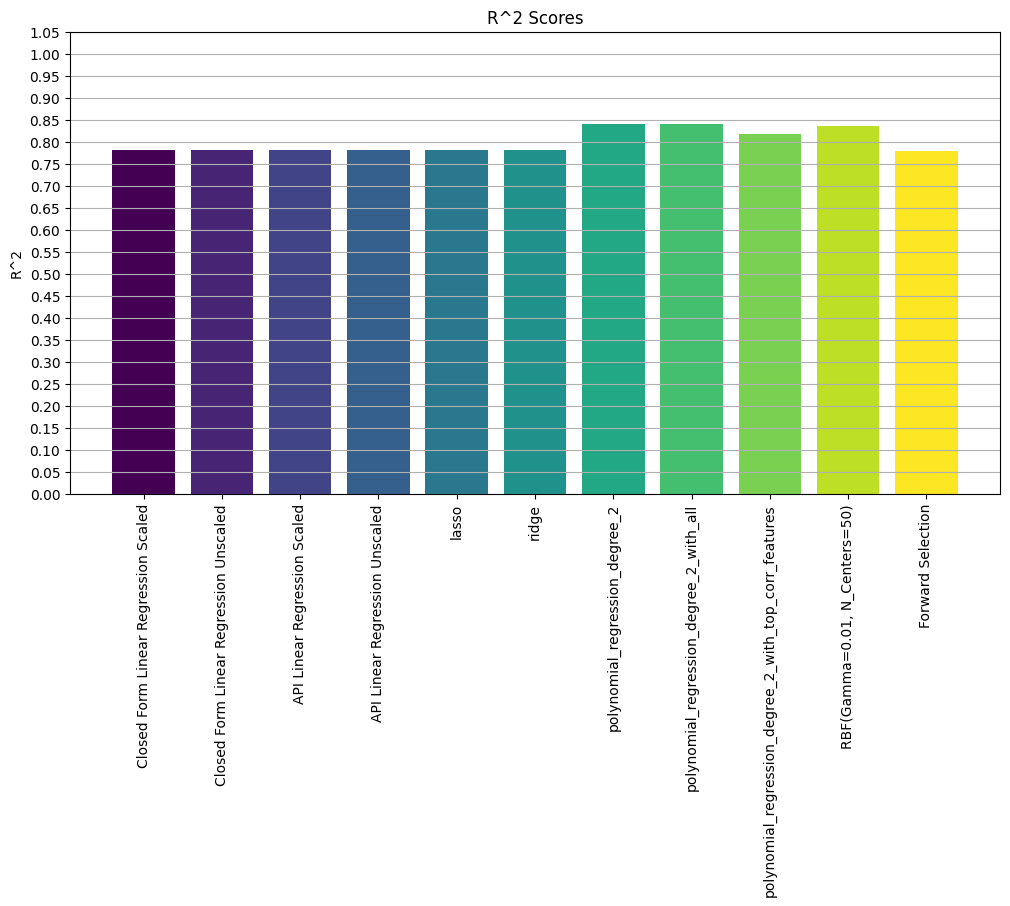

In [ ]:
#draw r2 scores
plt.figure(figsize=(12, 6))
plt.bar(r2_scores.keys(), r2_scores.values(), color=plt.cm.viridis(np.linspace(0, 1, len(r2_scores))))
plt.title('R^2 Scores')
plt.ylabel('R^2')
plt.xticks(rotation=90)
plt.grid(axis='y')
# make y axis from 0 to 1 eith sterp 0.2

plt.yticks(np.arange(0, 1.1, step=0.05))
plt.show()

In [ ]:
print("The best model is the one with the highest R^2 score:")
best_model = max(r2_scores, key=r2_scores.get)
print(f"Best Model: {best_model}")
print(f"R^2: {r2_scores[best_model]}")

The best model is the one with the highest R^2 score:
Best Model: polynomial_regression_degree_2
R^2: 0.8398070557788818


## testing the models

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

n_centers = 50
gamma = 0.01

centers = X_train.sample(n=n_centers, random_state=42).values

X_train_rbf = radial_basis_function(X_train, centers, gamma)

lr_rbf = LinearRegression()
lr_rbf.fit(X_train_rbf, y_train)


y_pred = lr_rbf.predict(radial_basis_function(X_test, centers, gamma))

r2_rbf = r2_score(y_test, y_pred)

print(f'R^2 RBF: {r2_rbf}')




X_rbf shape: (3675, 51)
X_rbf shape: (1225, 51)
R^2 RBF: 0.676804505636523


In [ ]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

y_test_pred = lr_poly.predict(X_test_poly)

r2_poly = r2_score(y_test, y_test_pred)

print(f'R^2 Polynomial: {r2_poly}')


R^2 Polynomial: 0.7105339785438287


In [ ]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

lasso = Lasso(alpha=0.01)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

r2_lasso = r2_score(y_test, y_pred)

print(f'R^2 Lasso: {r2_lasso}')

R^2 Lasso: 0.6031842428966894


In [ ]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

ridge = Ridge(alpha=1)

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

r2_ridge = r2_score(y_test, y_pred)

print(f'R^2 Ridge: {r2_ridge}')

R^2 Ridge: 0.6051431586047662


In [ ]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_api_linear = r2_score(y_test, y_pred)
print(f'R^2 API Linear Regression: {r2_api_linear}')

R^2 API Linear Regression: 0.6051814022272533


In [ ]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(car_df_scaled, 'price_usd')

w = closed_form_solution(X_train, y_train)
for i in range(X_train.shape[1]):
    print(f'w{i} = {w[i]}')

print('\n=======================================\n')

y_pred = X_test.dot(w)
r2_closed_linear = r_squared(y_test, y_pred)

print(f'R^2 Closed Form Linear Regression: {r2_closed_linear}')

w0 = -0.23725302999550094
w1 = 0.3216313510433607
w2 = 0.6762155881587238
w3 = 0.052800607970279495
w4 = -0.049106271442436025
w5 = -0.004269799146976194
w6 = -0.012660144820752435
w7 = 0.03401368137114631
w8 = -0.007764849565426215
w9 = -0.012383058958748513
w10 = -0.0049939638083270725
w11 = 0.002844116330304756
w12 = 0.016361844633390413


R^2 Closed Form Linear Regression: 0.6055217388211498
